# Process puntual sensors data from UPNA test track and generate high-level information
vers 1.04 dic2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

#create an array with the strings '00_romo', '01_Tajonar01_12.json' ... '01_Tajonar01_23.json'
#and store it in the variable 'files'
files = ['00_romo.json', '01_Tajonar01_12.json', '02_Tajonar02_12.json','03_Sadar03_10.json' ,'04_Sadar04_20.json', '05_Sadar05_20.json', '06_Sadar06_22.json']

#loop over files and get the json content of each file
#store the data in the variable 'data'

df = pd.DataFrame()
for file in files:
    with open(file, 'r') as f:
        this_data = json.load(f)
        records = this_data.get("data", [])
        # add the data to the dataframe using pd.concat
        df = pd.concat([df, pd.DataFrame(records, columns=['number', 'ID', 'timestamp', 'speed' , 'accel', 'way', 'vehicle', 'weight', 'sim', 'none1','none2','none3'])])


        #df = df.append(pd.DataFrame(records, columns=['number', 'ID', 'timestamp', 'speed' , 'accel', 'way', 'vehicle', 'weight', 'sim', 'none1','none2','none3']))
        # add a column with the name of the file
        df['filename'] = file

#create a new column from the timestamp with the numeric value of the hour
df['hour'] =  pd.to_numeric(pd.to_datetime(df['timestamp']).dt.hour) + pd.to_numeric(pd.to_datetime(df['timestamp']).dt.minute)/60
df['weekday'] = pd.to_datetime(df['timestamp']).dt.weekday
#get the two first characters of column ID and store them in a new column called 'point'
df['point'] =  pd.to_numeric(df['ID'].str[:2])
df['lane'] =  pd.to_numeric(df['ID'].str[2:4])
df['sensor'] =  pd.to_numeric(df['ID'].str[4:6])

#export to csv
#df.to_csv('data21ene2024.csv', index=False)

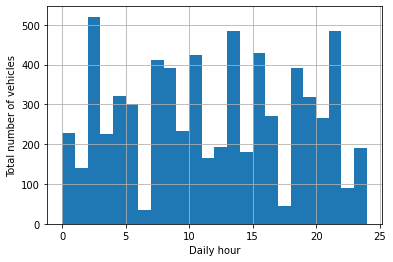

In [2]:
#plot an histogram of the hour column
df['hour'].hist(bins=24)
#set x axis text
plt.xlabel('Daily hour')
#set y axis text
plt.ylabel('Total number of vehicles')
plt.show()


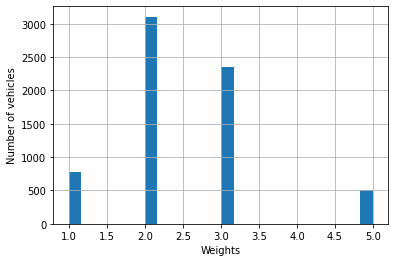

In [3]:
#plot an histogram of the weight distribution
df['weight'].hist(bins=24)
#set x axis text
plt.xlabel('Weights')
#set y axis text
plt.ylabel('Number of vehicles')
plt.show()

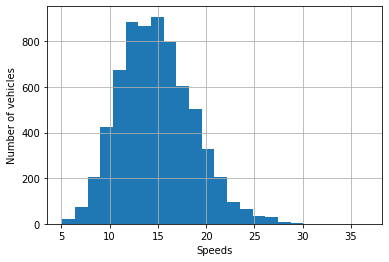

In [4]:
#plot an histogram of the speeds distribution
df['speed'].hist(bins=24)
#set x axis text
plt.xlabel('Speeds')
#set y axis text
plt.ylabel('Number of vehicles')
plt.show()

In [9]:
df['sim']

0      1111111
1      1111111
2      1111111
3      1111111
4      1111111
        ...   
786    1111111
787    1111111
788    1111111
789    1111111
790    1111111
Name: sim, Length: 6738, dtype: object

## anomaly detection using Isolation Forest

In [5]:
#ojo! usa solo las columnas speed, weight, hour y weekday
from sklearn.ensemble import IsolationForest

data = df.copy()

# Preprocessing
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Handle missing values (simple fillna, customize as needed)
data.fillna(method='ffill', inplace=True)


# Anomaly Detection using Isolation Forest
clf = IsolationForest(contamination=0.01   )  # Adjust contamination parameter as needed, default = 0.1
data['anomaly'] = clf.fit_predict(data[['speed', 'weight', 'hour', 'weekday']])

# Identifying anomalies
anomalies = data[data['anomaly'] == -1]

# Output anomalies or save the modified dataset
#anomalies.to_csv('detected_anomalies.csv', index=False)

anomalies.shape

c:\Users\adolf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(68, 19)

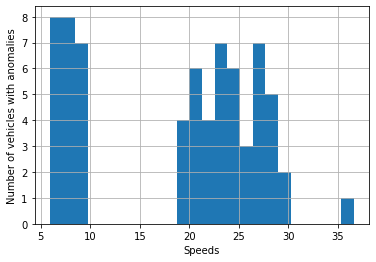

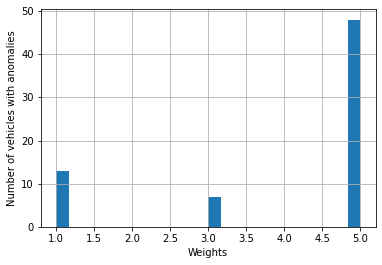

In [6]:

#plot an histogram of the anomalies distribution
anomalies['speed'].hist(bins=24)
#set x axis text
plt.xlabel('Speeds')
#set y axis text
plt.ylabel('Number of vehicles with anomalies')
plt.show()

anomalies['weight'].hist(bins=24)
#set x axis text
plt.xlabel('Weights')
#set y axis text
plt.ylabel('Number of vehicles with anomalies')
plt.show()


## anomaly detection based on autoencoders


In [9]:
#ojo! usa solo las columnas speed, weight, hour y weekday
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler

data = df.copy()

# Preprocessing and Feature Engineering
data['timestamp'] = pd.to_datetime(data['timestamp'])
features = data[['speed', 'weight', 'hour', 'weekday']]

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Define Autoencoder Architecture
input_dim = scaled_features.shape[1]
input_layer = Input(shape=(input_dim, ))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and Train
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(scaled_features, scaled_features, epochs=50, batch_size=32, shuffle=True)

# Reconstruction Error Calculation
predictions = autoencoder.predict(scaled_features)
mse = np.mean(np.power(scaled_features - predictions, 2), axis=1)
data['reconstruction_error'] = mse

# Determine a threshold for anomaly detection (customize based on your dataset)
threshold = np.quantile(data['reconstruction_error'], 0.99) # 99th percentile as threshold

# Identifying anomalies
data['anomaly'] = data['reconstruction_error'] > threshold

# Output anomalies or save the modified dataset
anomalies = data[data['anomaly'] == True]

#anomalies.to_csv('detected_anomalies_autoencoder.csv', index=False)


ModuleNotFoundError: No module named 'keras'

In [14]:
anomalies.shape

(68, 19)